In [1]:
import torch
import pandas as pd
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import gc
import random
import numpy as np
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor
from transformers import get_constant_schedule_with_warmup

In [2]:
def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [14]:
HF_DATASET_NAME = "data354/Koumankan_mt_dyu_fr"
SRC_LANG = "dyu_Latn"
TGT_LANG = "fra_Latn"
# MODEL_CHECKPOINT = "facebook/nllb-200-1.3B"
# MODEL_CHECKPOINT = "facebook/nllb-200-3.3B"
MODEL_CHECKPOINT = "facebook/nllb-200-distilled-600M"
TOKENIZER_PATH = "../saved_model/tokenizer/"
MODEL_PATH = "../saved_model/nllb/"
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

Download model from HuggingFace Hub

In [2]:
# # Install dependencies
# !pip install -r "train_requirements.txt"

In [ ]:
# !pip install -U "huggingface_hub[cli]"
# !pip install ipywidgets

In [52]:
try:
  del tokenizer
  del model
except:
  pass

In [1]:
# with open("token.txt", "r") as token_file:
#     from huggingface_hub import login
#     login(token=token_file.readline())

# tokenizer = AutoTokenizer.from_pretrained(
#   MODEL_CHECKPOINT, token=True, src_lang=SRC_LANG, tgt_lang=TGT_LANG
# )

# model = AutoModelForSe²q2SeqLM.from_pretrained(MODEL_CHECKPOINT).to(DEVICE)

Load model from local files

In [15]:
tokenizer = AutoTokenizer.from_pretrained(
    TOKENIZER_PATH,
    local_files_only = True,
    src_lang = SRC_LANG,
    tgt_lang = TGT_LANG
)

In [5]:
model = AutoModelForSeq2SeqLM.from_pretrained(
    MODEL_PATH,
    local_files_only = True,
).to(DEVICE)

In [17]:
tokenizer.src_lang = SRC_LANG
tokenizer.tgt_lang = TGT_LANG

inputs = tokenizer("Nne ye amɛrikɛn ye.", return_tensors="pt").to(DEVICE) # Je suis Américain
# inputs = tokenizer("A y'a dabla ka yɛlɛ n na.", return_tensors="pt").to(DEVICE) # Arrêter de vous moquer de moi
# inputs = tokenizer("A bi ji min na", return_tensors="pt").to(DEVICE) # Il boit de l'eau

out = model.generate(**inputs, forced_bos_token_id=tokenizer.lang_code_to_id["fra_Latn"])

tokenizer.decode(out[0], skip_special_tokens=True)

'Ma grand-mère est une amérindienne.'

In [49]:
# model.save_pretrained("./models/nllb/")

In [50]:
# tokenizer.save_pretrained("./models/tokenizer/")

# Data Load

In [18]:
dataset = load_dataset(HF_DATASET_NAME)

In [24]:
dataset["train"]["translation"][:10]

[{'dyu': 'A bi ji min na', 'fr': 'Il boit de l’eau.'},
 {'dyu': 'A le dalakolontɛ lon bɛ.', 'fr': 'Il se plaint toujours.'},
 {'dyu': 'Mun? Fɛn dɔ.', 'fr': 'Quoi ? Quelque chose.'},
 {'dyu': 'O bɛ bi bɔra fo Gubeta.', 'fr': 'Tous sortent excepté Gubetta.'},
 {'dyu': 'A ale lo bi da bugɔ la!', 'fr': 'Ah ! c’est lui… il sonne…'},
 {'dyu': "E nafa t'a ra.", 'fr': 'Et sans rapport.'},
 {'dyu': 'Sanu baa de bi n bolo', 'fr': "J'ai suffisamment d'or."},
 {'dyu': 'Onhon mɛ laɲini jumanan', 'fr': 'Oui ; mais dans quel but ?'},
 {'dyu': 'Kamele baba', 'fr': 'de grands gars forts.'},
 {'dyu': 'Duguden dɔ minɛ na.', 'fr': 'Un civil a été capturé?!'}]

# Train

In [7]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

In [8]:
batch_size = 16  # 32 already doesn't fit well to 15GB of GPU memory
max_length = 128
warmup_steps = 1_000
training_steps = 57000

In [9]:
losses = []
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

In [10]:
model.train()
x, y, loss = None, None, None
cleanup()

In [11]:
tq = trange(len(losses), training_steps)

  0%|          | 0/57000 [00:00<?, ?it/s]

In [ ]:
loss = None
for i in trange(0, len(dataset["train"])):
# for i in trange(1):
  xx = dataset["train"]["translation"][i]["dyu"]
  yy = dataset["train"]["translation"][i]["fr"]

  try:
      tokenizer.src_lang = SRC_LANG
      tokenizer.tgt_lang = TGT_LANG
      x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)

      tokenizer.src_lang = TGT_LANG
      tokenizer.tgt_lang = SRC_LANG
      y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
      y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

      loss = model(**x, labels=y.input_ids).loss
      loss.backward()
      losses.append(loss.item())

      optimizer.step()
      optimizer.zero_grad(set_to_none=True)
      scheduler.step()

  except RuntimeError as e:
      optimizer.zero_grad(set_to_none=True)
      x, y, loss = None, None, None
      cleanup()
      print('error', max(len(s) for s in xx + yy), e)

  0%|          | 0/8065 [00:00<?, ?it/s]

<Axes: >

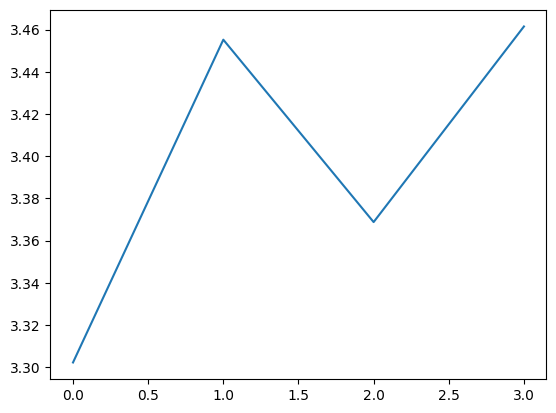

In [23]:
pd.Series(losses).ewm(100).mean().plot()